In [447]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from catboost import CatBoostRegressor




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer



PREPROCESSING : ADDING NEW FEATURES AND SPLITTING DATASET

In [448]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)


x_train_imputed



,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
0,1054.0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,-0.789557,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.0,1.0
1,2049.0,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0.0,1.0
2,1924.0,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0.0,1.0
3,297.0,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1.0,0.0
4,1101.0,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,-0.471847,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,-0.238427,0.876984,0.819520,1.320373,1.0,0.0
1490,1674.0,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,-1.071237,0.932633,-0.085690,0.356356,0.0,1.0
1491,748.0,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,1.0,0.0
1492,1454.0,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.619473,0.918251,0.378080,-0.973969,-0.828580,-0.137667,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,0.0,1.0


In [449]:
x_train_imputed['FR_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['FR_WINDPOW']))
x_train_imputed['DE_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['DE_WINDPOW']))

x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()

x_train_imputed['FR_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_RESIDUAL_LOAD'].cumsum()
x_train_imputed['DE_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_RESIDUAL_LOAD'].cumsum()

x_train_imputed['FR_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR']
x_train_imputed['FR_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

x_train_imputed['DE_NON_RENEWABLE'] = x_train_imputed['DE_COAL']+ x_train_imputed['DE_GAS'] + x_train_imputed['DE_NUCLEAR'] + x_train_imputed['DE_LIGNITE']
x_train_imputed['DE_RENEWABLE'] = x_train_imputed['DE_HYDRO']+ x_train_imputed['DE_SOLAR'] + x_train_imputed['DE_WINDPOW']

x_train_imputed['EXCESS_PROD_FR'] = x_train_imputed['FR_NON_RENEWABLE']+x_train_imputed['FR_RENEWABLE'] - x_train_imputed['FR_CONSUMPTION']- x_train_imputed['FR_NET_EXPORT']
x_train_imputed['EXCESS_PROD_DE'] =  x_train_imputed['DE_NON_RENEWABLE']+x_train_imputed['DE_RENEWABLE'] - x_train_imputed['DE_CONSUMPTION']- x_train_imputed['DE_NET_EXPORT']

x_train_imputed.drop(['ID', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_TEMP'], axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)


In [450]:
columns_to_exclude = ['DAY_ID', 'COUNTRY_FR', 'COUNTRY_DE']

columns_to_standardize = [col for col in x_train_imputed.columns if col not in columns_to_exclude]
scaler = StandardScaler()
x_train_imputed[columns_to_standardize] = scaler.fit_transform(x_train_imputed[columns_to_standardize])


In [451]:
fr_x_train = x_train_imputed[x_train_imputed['COUNTRY_FR'] == 1]
de_x_train = x_train_imputed[x_train_imputed['COUNTRY_DE'] == 1]
y_train_fr = y_train[x_train_imputed['COUNTRY_FR'] == 1]
y_train_de = y_train[x_train_imputed['COUNTRY_DE'] == 1]

In [452]:
fr_x_train.sort_values('DAY_ID', inplace = True)
de_x_train.sort_values('DAY_ID', inplace = True)
y_train_fr = y_train_fr.loc[fr_x_train.index]
y_train_de = y_train_de.loc[de_x_train.index]

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_61484/4160478158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr_x_train.sort_values('DAY_ID', inplace = True)
/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_61484/4160478158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_x_train.sort_values('DAY_ID', inplace = True)


In [453]:
y_ma_fr = y_train_fr['TARGET'].shift(1).rolling(window=5, min_periods=1).mean()
y_ma_de = y_train_de['TARGET'].shift(1).rolling(window=5, min_periods=1).mean()

y_ma_fr = y_ma_fr.rename('MA_Target_fr')
y_ma_de = y_ma_de.rename('MA_Target_de')

X_train_FR = pd.concat([fr_x_train, y_ma_fr], axis=1)
X_train_DE = pd.concat([de_x_train, y_ma_de], axis=1)

X_train_FR = X_train_FR[1:]
X_train_DE = X_train_DE[1:]

y_train_fr = y_train_fr[1:]
y_train_de = y_train_de[1:]

X_train_DE.drop(columns = ['COUNTRY_FR', 'COUNTRY_DE'], inplace = True)
X_train_FR.drop(columns = ['COUNTRY_FR', 'COUNTRY_DE'], inplace = True)

BASELINE XGBOOST GERMANY

In [454]:
xgb_reg = XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=42)

mse_valid = cross_val_score(xgb_reg, X_train_DE, y_train_de, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for Germany : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, X_train_DE, y_train_de, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for Germany: {-np.mean(mae_scores)}')



Average MSE for Germany : 1.1286985918108914
Average MAE for Germany: 0.6638381786412861


In [455]:
xgb_reg.fit(X_train_DE, y_train_de)
booster = xgb_reg.get_booster()
importance_dict = booster.get_fscore()
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Create a DataFrame with sorted feature importances
feature_importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])
print("Feature Importances for Germany (Sorted by Absolute Value):")
print(feature_importance_df.to_string())

Feature Importances for Germany (Sorted by Absolute Value):
                    Feature  Importance
0             DE_NET_EXPORT   -0.253268
1               DE_WIND_SQR   -0.240963
2          DE_RESIDUAL_LOAD    0.224726
3            DE_CONSUMPTION    0.157565
4                DE_LIGNITE   -0.153046
5                  DE_HYDRO    0.140213
6                  DE_SOLAR   -0.134329
7                   DE_COAL   -0.131996
8              DE_RENEWABLE   -0.121147
9              MA_Target_de    0.119647
10               DE_NUCLEAR   -0.102371
11           FR_DE_EXCHANGE   -0.096660
12     FR_NET_EXPORT_cumsum    0.092771
13           DE_FR_EXCHANGE    0.092667
14         DE_NON_RENEWABLE   -0.090285
15  DE_RESIDUAL_LOAD_cumsum   -0.086299
16               FR_WINDPOW   -0.084868
17     DE_NET_EXPORT_cumsum    0.073269
18         FR_RESIDUAL_LOAD    0.072106
19            FR_NET_EXPORT   -0.071112
20               DE_WINDPOW   -0.069976
21              FR_WIND_SQR    0.066704
22               FR_

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_61484/2713459932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Importance'] = top_10['Importance']


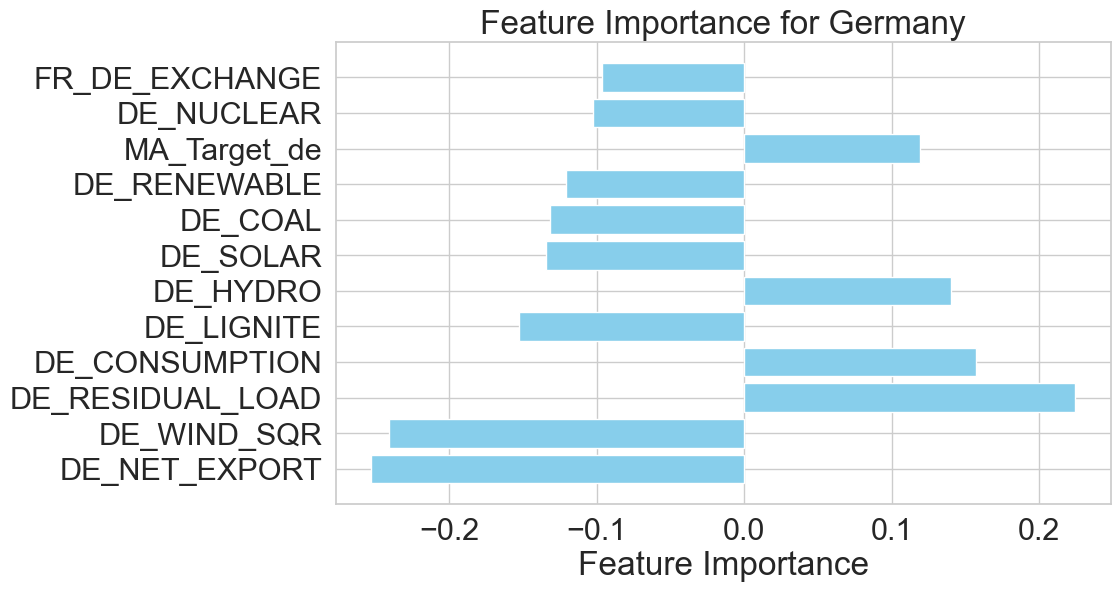

In [456]:
top_10 = feature_importance_df[:12]

# Assign absolute values to the 'Importance' column
top_10['Importance'] = top_10['Importance']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Germany')
plt.show()

In [457]:
mse_scores_per_k = []
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

for k in range(1, len(X_train_DE.columns)+1):
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    xgb_reg_selected = XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=42)

    mse_scores = cross_val_score(xgb_reg_selected, X_train_DE[selected_features], y_train_de, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

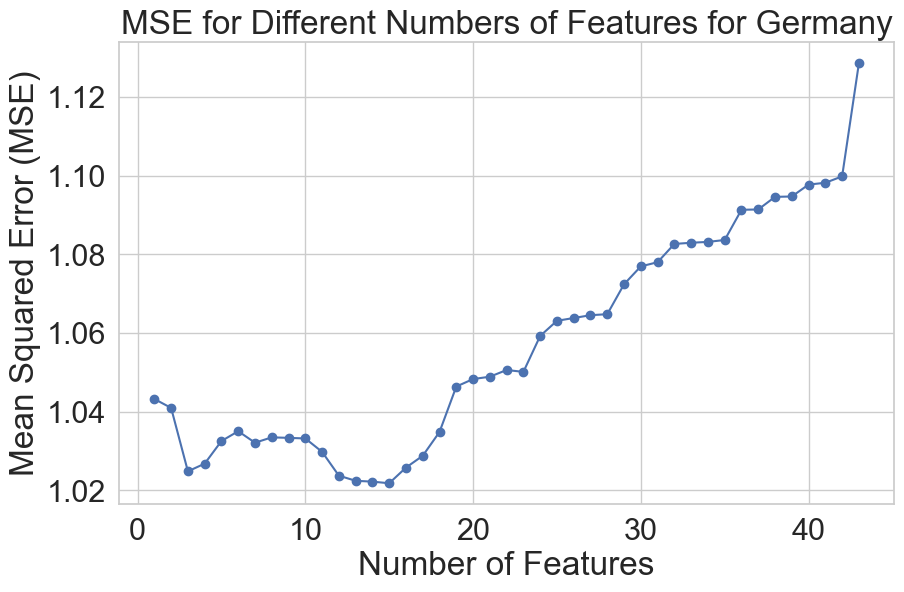

In [458]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_DE.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('MSE for Different Numbers of Features for Germany')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

    

In [459]:
selected_features_DE = [feature[0] for feature in sorted_importances[:12]]

X_train_DE = X_train_DE[selected_features_DE] 

mse_valid = cross_val_score(xgb_reg, X_train_DE, y_train_de, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for Germany : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, X_train_DE, y_train_de, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for Germany: {-np.mean(mae_scores)}')

r2_scores = cross_val_score(xgb_reg, X_train_DE, y_train_de, scoring='r2', cv=5)
print(f'Average R2 for Germany: {np.mean(r2_scores)}')



Average MSE for Germany : 1.023870835525463
Average MAE for Germany: 0.6205434515449093
Average R2 for Germany: 0.05860332063663391


BASELINE XGBOOST : FRANCE

In [460]:
mse_valid = cross_val_score(xgb_reg, X_train_FR, y_train_fr, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for France: {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, X_train_FR, y_train_fr, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for France: {-np.mean(mae_scores)}')

Average MSE for France: 1.0970998098096605
Average MAE for France: 0.5726088096497524


In [461]:
xgb_reg.fit(X_train_FR, y_train_fr)
booster = xgb_reg.get_booster()
importance_dict = booster.get_fscore()
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Create a DataFrame with sorted feature importances
feature_importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])
print("Feature Importances for France (Sorted by Absolute Value):")
print(feature_importance_df.to_string())

Feature Importances for France (Sorted by Absolute Value):
                    Feature  Importance
0                FR_WINDPOW   -0.260797
1               FR_WIND_SQR    0.226814
2                  FR_HYDRO    0.190906
3             DE_NET_EXPORT   -0.145509
4            DE_CONSUMPTION   -0.142030
5              MA_Target_fr   -0.133773
6                   FR_WIND    0.122632
7            DE_FR_EXCHANGE    0.099869
8                DE_WINDPOW    0.098082
9      FR_NET_EXPORT_cumsum   -0.097002
10           EXCESS_PROD_DE    0.089664
11  FR_RESIDUAL_LOAD_cumsum   -0.088648
12               FR_NUCLEAR    0.079752
13             FR_RENEWABLE   -0.078413
14                   DE_GAS   -0.073428
15               CARBON_RET    0.056688
16           FR_DE_EXCHANGE   -0.055251
17                  DE_RAIN   -0.047145
18               DE_NUCLEAR    0.043563
19                 DE_SOLAR   -0.043552
20                  FR_RAIN   -0.041201
21         FR_NON_RENEWABLE    0.039198
22              DE_WI

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_61484/3696782194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Importance'] = top_10['Importance']


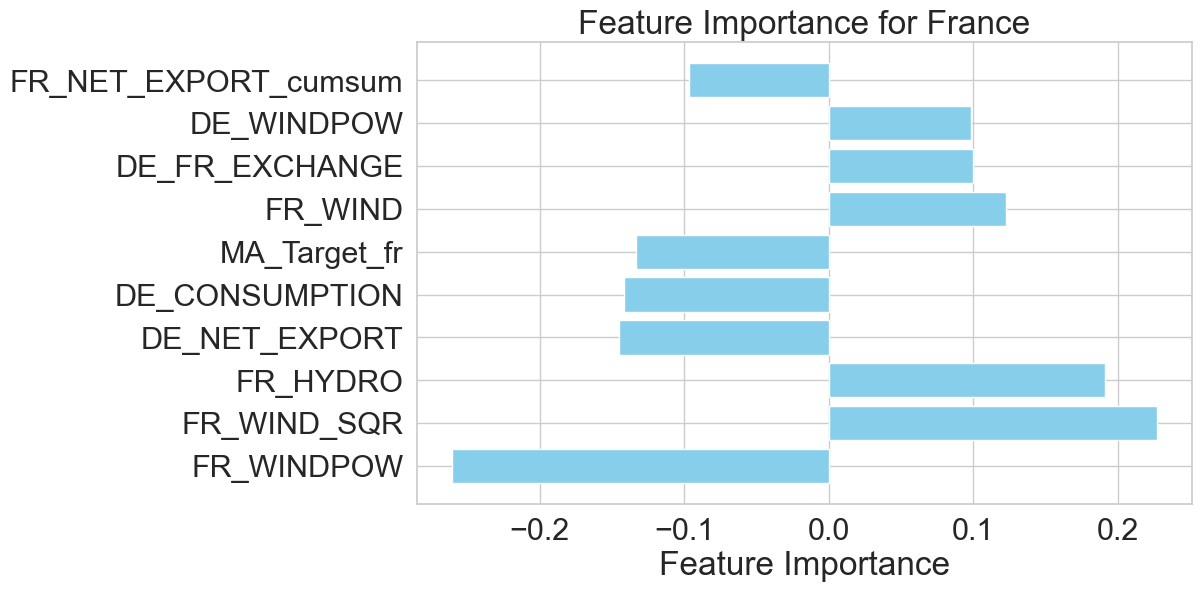

In [462]:
top_10 = feature_importance_df[:10]

# Assign absolute values to the 'Importance' column
top_10['Importance'] = top_10['Importance']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for France')
plt.show()

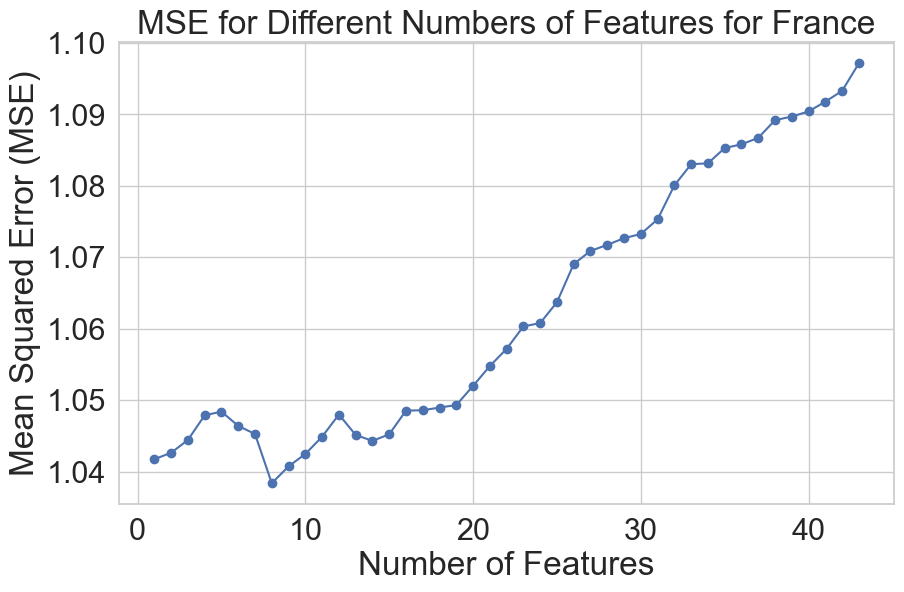

In [463]:
mse_scores_per_k = []
sorted_importances = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

for k in range(1, len(X_train_FR.columns)+1):
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    xgb_reg_selected = XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=42)

    mse_scores = cross_val_score(xgb_reg_selected, X_train_FR[selected_features], y_train_fr, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_FR.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('MSE for Different Numbers of Features for France')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


In [464]:
selected_features_FR = [feature[0] for feature in sorted_importances[:8]]

X_train_FR = X_train_FR[selected_features_FR] 

mse_valid = cross_val_score(xgb_reg, X_train_FR, y_train_fr, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for France : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg, X_train_FR, y_train_fr, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for France: {-np.mean(mae_scores)}')

r2_scores = cross_val_score(xgb_reg, X_train_FR, y_train_fr, scoring='r2', cv=5)
print(f'Average R2 for France: {np.mean(r2_scores)}')

Average MSE for France : 1.038342047475966
Average MAE for France: 0.5436302053914822
Average R2 for France: 0.0011273175903886879


HYPERPARAMETER TUNING : GERMANY

In [465]:
#randomized grid search
params = {
    'learning_rate': [0.001, 0.002, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.4, 0.5, 0.45, 0.42],
    'lambda': [0.05, 0.08, 0.1, 0.15, 0.2, 0.5, 1, 1.5, 2],
    'alpha': [0, 0.1, 0.5, 1, 2],
}


random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=params,
    n_iter=500,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train_DE, y_train_de)
print("Best Parameters for Germany:", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

mean_cv_score = random_search.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score}')



Best Parameters for Germany: {'learning_rate': 0.25, 'lambda': 0.1, 'alpha': 0}
Mean Cross-Validated Score: 1.0173825472349673


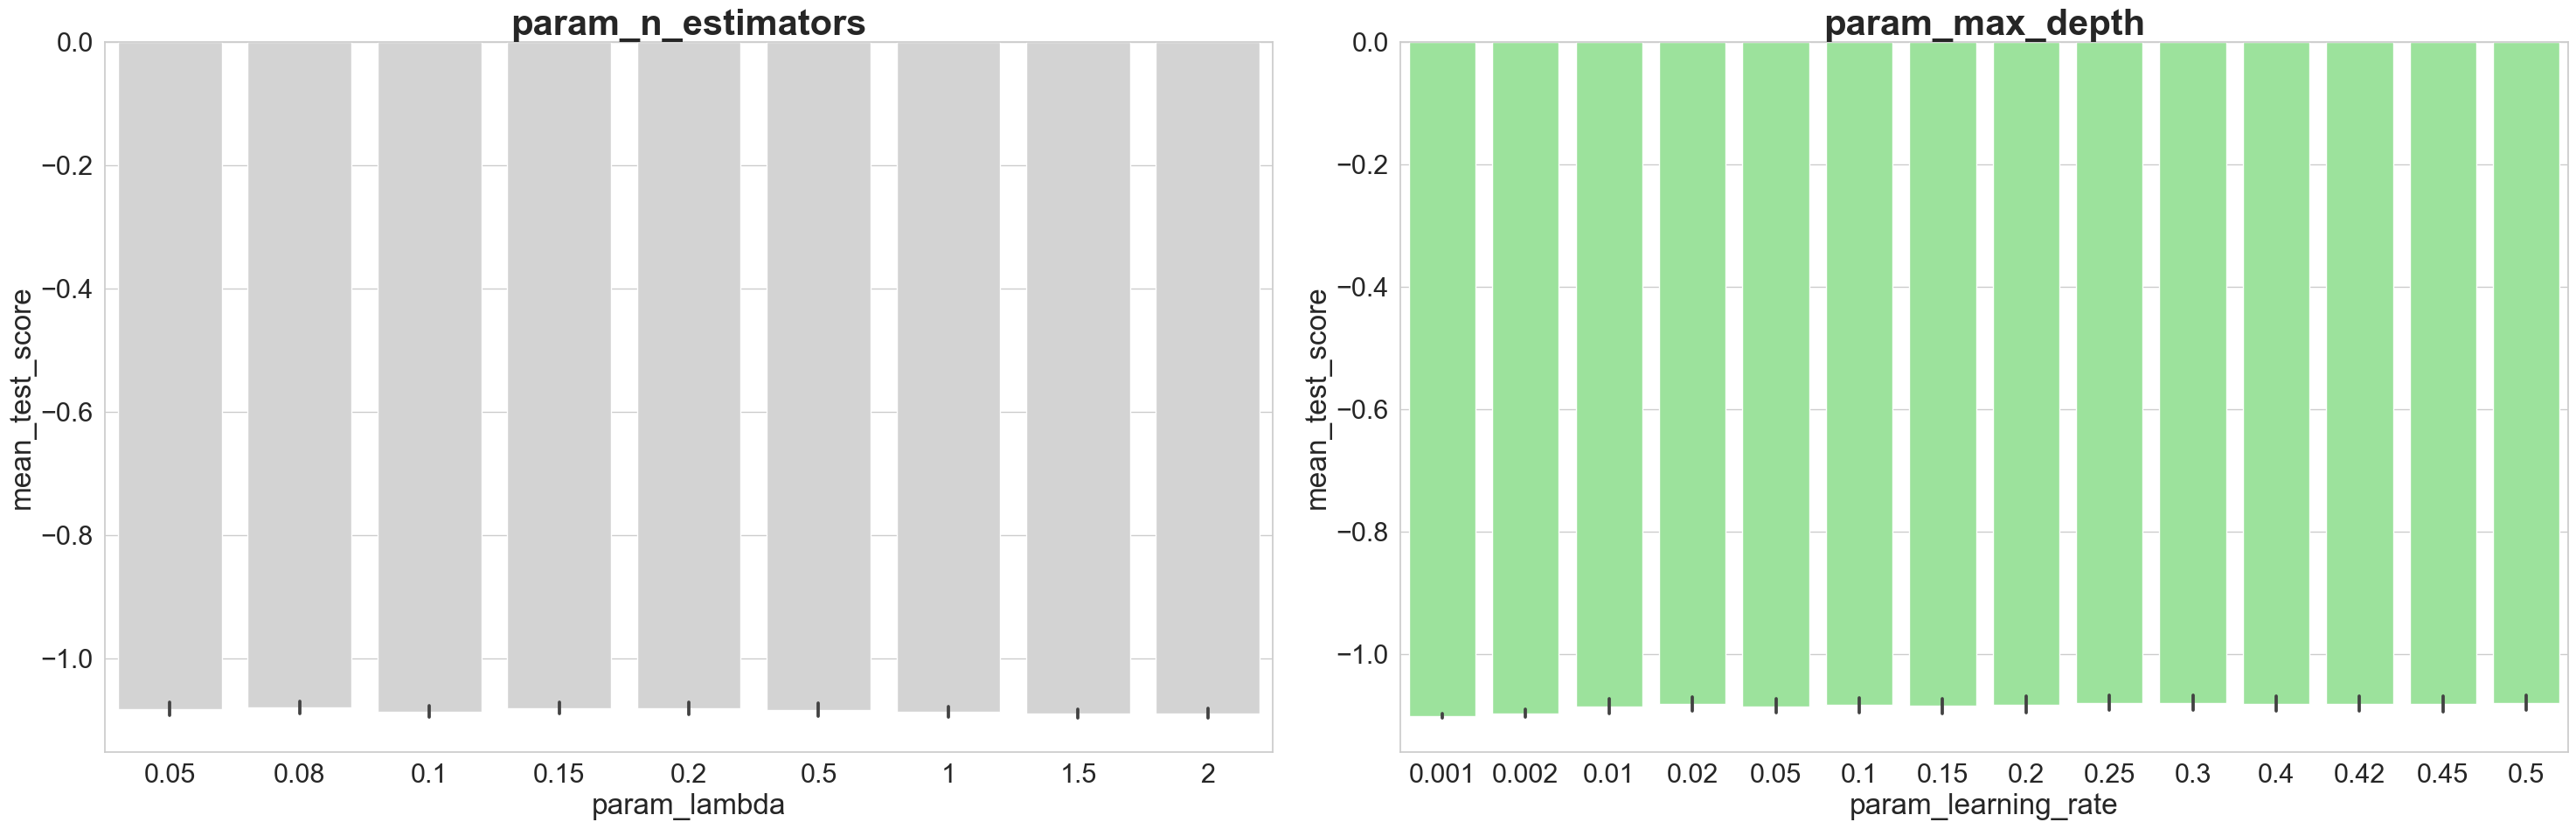

In [466]:
rs_df = pd.DataFrame(random_search.cv_results_)

# Visualize the results using bar plots
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(30, 10)

sns.barplot(x='param_lambda', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')
axs[0].set_title(label='param_n_estimators', size=30, weight='bold')

sns.barplot(x='param_learning_rate', y='mean_test_score', data=rs_df, ax=axs[1], color='lightgreen')
axs[1].set_title(label='param_max_depth', size=30, weight='bold')


plt.tight_layout()
plt.show()

HYPERPARAMETER FRANCE

In [467]:
#randomized grid search
params = {
    'learning_rate': [0.001, 0.002, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.4, 0.5, 0.45, 0.42],
    'lambda': [0.05, 0.08, 0.1, 0.15, 0.2, 0.5, 1, 1.5, 2],
    'alpha': [0, 0.1, 0.5, 1, 2],
}


random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=params,
    n_iter=500,  
    scoring='neg_mean_squared_error', 
    cv=5,  
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train_FR, y_train_fr)
print("Best Parameters for France:", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

mean_cv_score = random_search.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score}')

Best Parameters for France: {'learning_rate': 0.5, 'lambda': 0.1, 'alpha': 0}
Mean Cross-Validated Score: 1.036165082360203


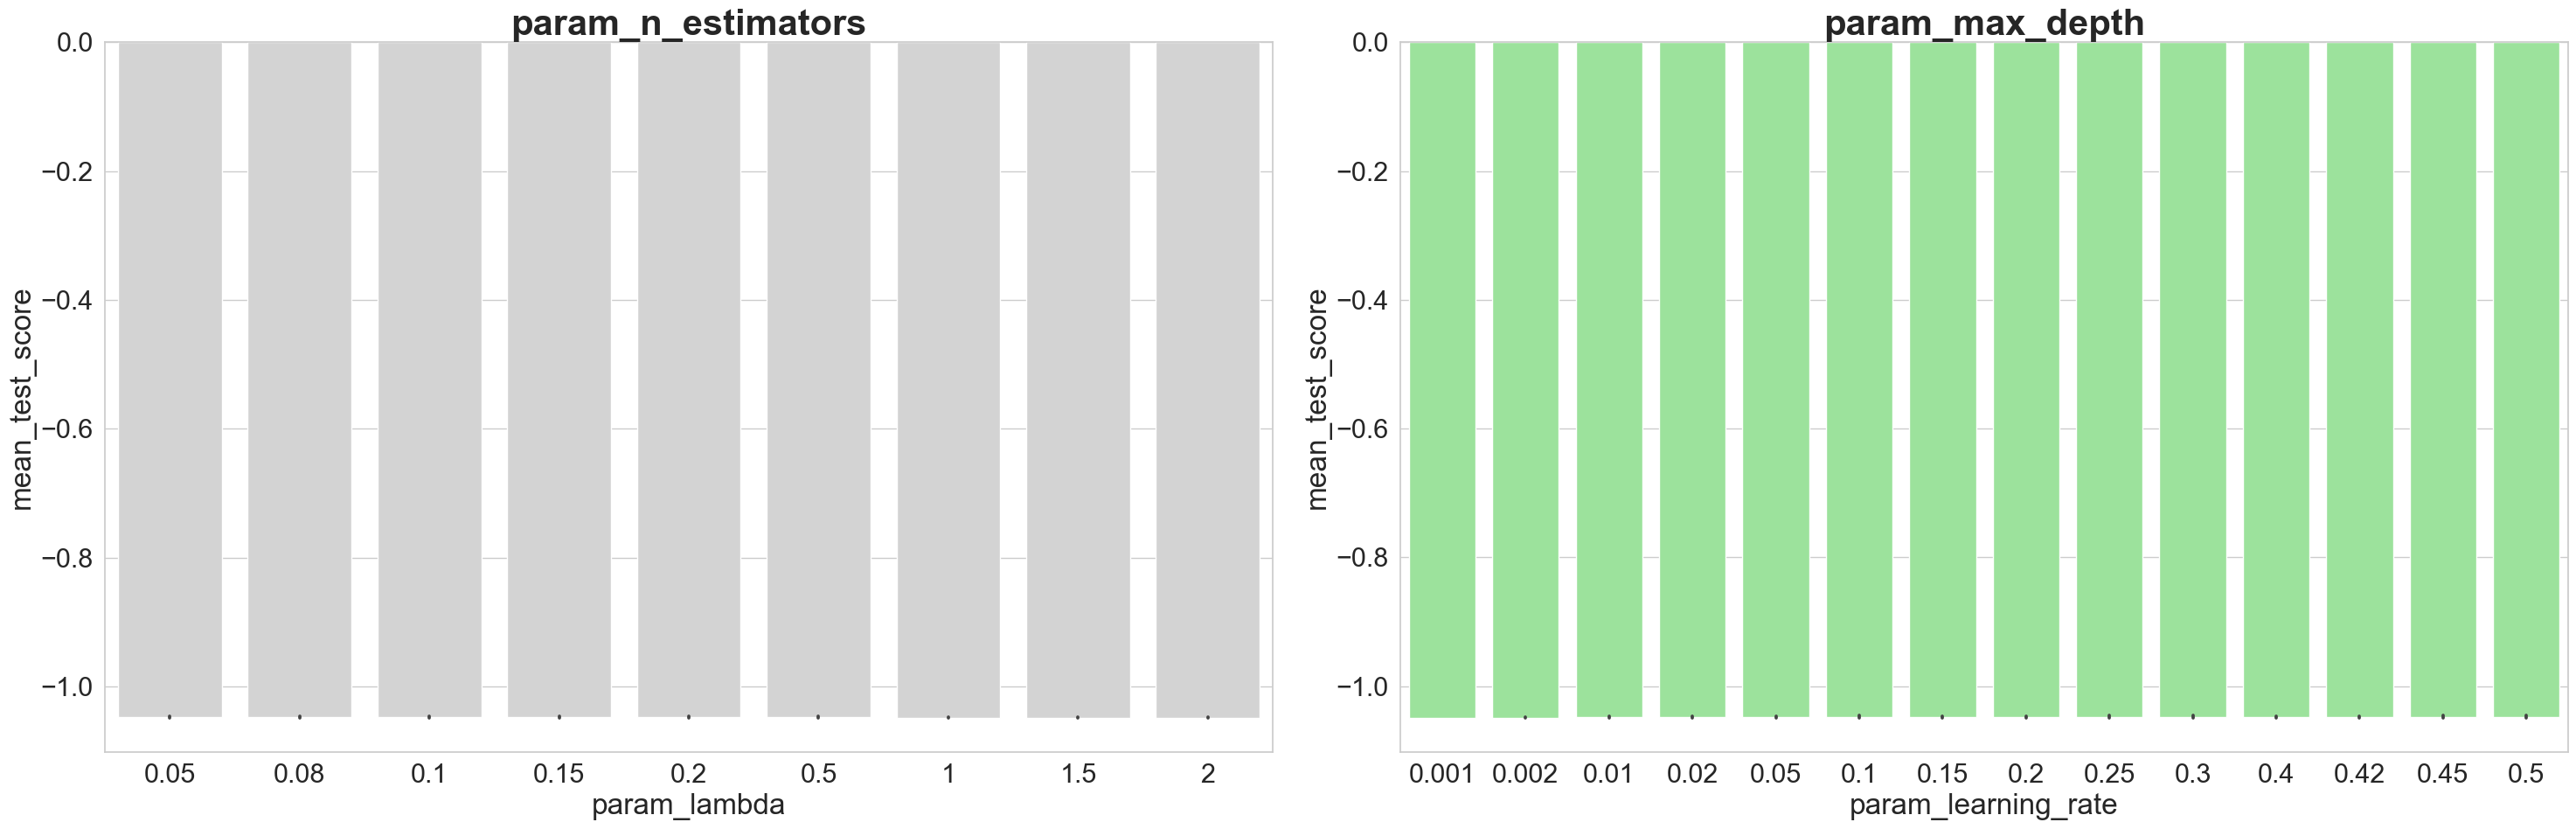

In [468]:
rs_df = pd.DataFrame(random_search.cv_results_)

# Visualize the results using bar plots
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig, axs = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(30, 10)

sns.barplot(x='param_lambda', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')
axs[0].set_title(label='param_n_estimators', size=30, weight='bold')

sns.barplot(x='param_learning_rate', y='mean_test_score', data=rs_df, ax=axs[1], color='lightgreen')
axs[1].set_title(label='param_max_depth', size=30, weight='bold')


plt.tight_layout()
plt.show()

FINAL RESULTS

In [469]:
def spearman_corr_scorer(y_true, y_pred):
    spearman_corr, _ = spearmanr(y_pred, y_true)
    return spearman_corr

xgb_reg_de = XGBRegressor(objective='reg:squarederror', booster='gblinear', learning_rate=0.25, reg_lambda=0.1, random_state=42)

mse_valid = cross_val_score(xgb_reg_de, X_train_DE, y_train_de, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for Germany : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg_de, X_train_DE, y_train_de, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for Germany: {-np.mean(mae_scores)}')

y_pred_de = cross_val_predict(xgb_reg_de, X_train_DE, y_train_de, cv=5)
spearman_corr_cv = spearman_corr_scorer(y_train_de, y_pred_de)
print(f'Average Spearman Correlation for Germany: {spearman_corr_cv}')

Average MSE for Germany : 1.0173891167017945
Average MAE for Germany: 0.6159972161078905
Average Spearman Correlation for Germany: 0.3723645616189535


In [470]:
xgb_reg_fr= XGBRegressor(objective='reg:squarederror', booster='gblinear', learning_rate=0.5, reg_lambda=0.1, random_state=42)

mse_valid = cross_val_score(xgb_reg_fr, X_train_FR, y_train_fr, scoring='neg_mean_squared_error', cv=5)
print(f'Average MSE for France : {-np.mean(mse_valid)}')

mae_scores = cross_val_score(xgb_reg_fr, X_train_FR, y_train_fr, scoring='neg_mean_absolute_error', cv=5)
print(f'Average MAE for France: {-np.mean(mae_scores)}')

y_pred_FR = cross_val_predict(xgb_reg_fr, X_train_FR, y_train_fr, cv=5)
spearman_corr_cv = spearman_corr_scorer(y_train_fr, y_pred_FR)
print(f'Average Spearman Correlation for France: {spearman_corr_cv}')

Average MSE for France : 1.0361657981049337
Average MAE for France: 0.5303246914737102
Average Spearman Correlation for France: 0.10664923031779998
